<a href="https://colab.research.google.com/github/mitrasubham/OpenCVLLM/blob/main/OpenCV_extract_table%20images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#from google.colab import drive
#drive.mount('/content/gdrive')
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sample=r'page1.png'
read_image= cv2.imread(sample,0)

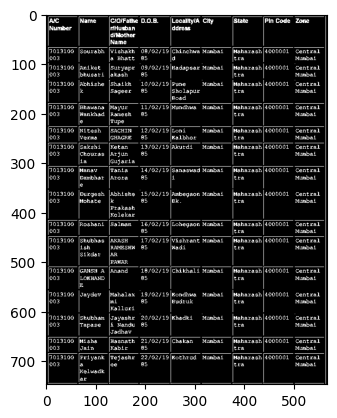

In [18]:
convert_bin,grey_scale = cv2.threshold(read_image,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
if grey_scale is not None:
  grey_scale = 255 - grey_scale
#else:
#  raise ValueError("Thresholding operation failed: grey_scale is None")
grey_graph = plt.imshow(grey_scale,cmap='gray')
plt.show()

In [19]:
length = np.array(read_image).shape[1]//100
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (length, 1))

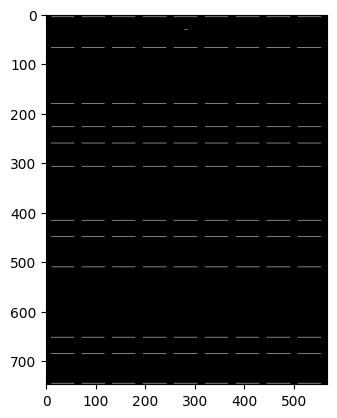

In [20]:
horizontal_detect = cv2.erode(grey_scale, horizontal_kernel, iterations=3)
hor_line = cv2.dilate(horizontal_detect, horizontal_kernel, iterations=3)
plotting = plt.imshow(horizontal_detect,cmap='gray')
plt.show()

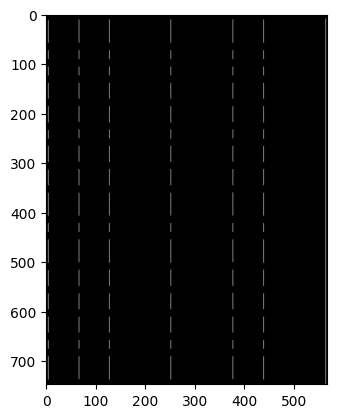

In [21]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, length))
vertical_detect = cv2.erode(grey_scale, vertical_kernel, iterations=3)
ver_lines = cv2.dilate(vertical_detect, vertical_kernel, iterations=3)
show = plt.imshow(vertical_detect,cmap='gray')
plt.show()

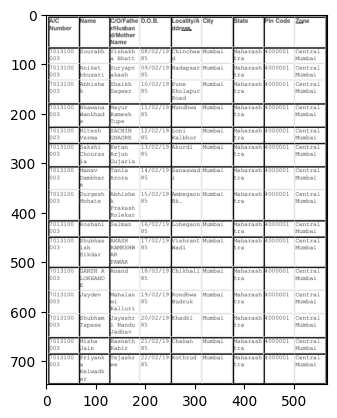

In [22]:
final = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
combine = cv2.addWeighted(ver_lines, 0.5, hor_line, 0.5, 0.0)
combine = cv2.erode(~combine, final, iterations=2)
thresh, combine = cv2.threshold(combine,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
convert_xor = cv2.bitwise_xor(read_image,combine)
inverse = cv2.bitwise_not(convert_xor)
output= plt.imshow(inverse,cmap='gray')
plt.show()

In [24]:
cont, _ = cv2.findContours(combine, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
def get_boxes(num, method="left-to-right"):
    invert = False
    flag = 0
    i=0
    if method == "right-to-left" or method == "bottom-to-top":
        invert = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        flag = 1
    boxes = [cv2.boundingRect(c) for c in num]
    (num, boxes) = zip(*sorted(zip(num, boxes), key=lambda b:b[1][i], reverse=invert))
    return (num, boxes)
cont, boxes = get_boxes(cont, method="top-to-bottom")

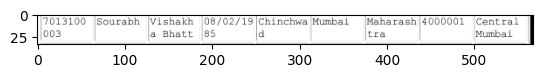

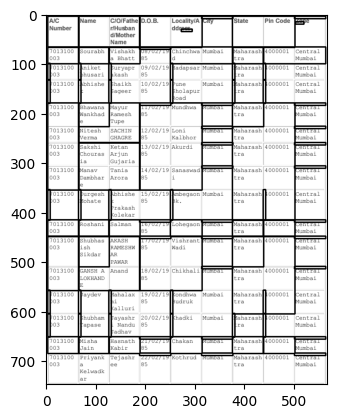

In [26]:
final_box = []
for c in cont:
    s1, s2, s3, s4 = cv2.boundingRect(c)
    if (s3<500 and s4<500):
        rectangle_img = cv2.rectangle(read_image,(s1,s2),(s1+s3,s2+s4),(0,255,0),2)
        final_box.append([s1,s2,s3,s4])
graph = plt.imshow(rectangle_img,cmap='gray')
plt.show()

In [28]:
dim = [boxes[i][3] for i in range(len(boxes))]
avg = np.mean(dim)
hor=[]
ver=[]
for i in range(len(boxes)):
    if(i==0):
        ver.append(boxes[i])
        last=boxes[i]
    else:
        if(boxes[i][1]<=last[1]+avg/2):
            ver.append(boxes[i])
            last=boxes[i]
            if(i==len(boxes)-1):
                hor.append(ver)
        else:
            hor.append(ver)
            ver=[]
            last = boxes[i]
            ver.append(boxes[i])
total = 0
for i in range(len(hor)):
    total = len(hor[i])
    if total > total:
        total = total
mid = [int(hor[i][j][0]+hor[i][j][2]/2) for j in range(len(hor[i])) if hor[0]]
mid=np.array(mid)
mid.sort()

In [32]:
order = []
for i in range(len(hor)):
    arrange=[]
    for k in range(total):
        arrange.append([])
    for j in range(len(hor[i])):
        sub = abs(mid-(dim[i][j][0]+dim[i][j][2]/4))
        lowest = min(sub)
        idx = list(sub).index(lowest)
        arrange[idx].append(dim[i][j])
    order.append(arrange)
#Now we will use the pytesseract to perform OCR since it is compatible with OpenCV and Python.

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
#We will take every box and perform eroding and dilating on it and then extract the information in the cells with OCR.

extract=[]
for i in range(len(order)):
    for j in range(len(order[i])):
        inside=''
        if(len(order[i][j])==0):
            extract.append(' ')
        else:
            for k in range(len(order[i][j])):
                side1,side2,width,height = order[i][j][k][0],order[i][j][k][1], order[i][j][k][2],order[i][j][k][3]
                final_extract = bitnot[side2:side2+h, side1:side1+width]
                final_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                get_border = cv2.copyMakeBorder(final_extract,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resize = cv2.resize(get_border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dil = cv2.dilate(resize, final_kernel,iterations=1)
                ero = cv2.erode(dil, final_kernel,iterations=2)
                ocr = pytesseract.image_to_string(ero)
                if(len(ocr)==0):
                    ocr = pytesseract.image_to_string(ero, config='--psm 3')
                inside = inside +" "+ ocr
            extract.append(inside)

TypeError: 'int' object is not subscriptable

In [ ]:
a = np.array(extract)
dataset = pd.DataFrame(a.reshape(len(hor), total))
dataset.to_excel("output1.xlsx")